In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
from dataloader_creator import CreatorDL
creator = CreatorDL(seed=42, bs=2048)

In [ ]:
df_UNSW = creator.reader("NF-UNSW-NB15-v3")

df_train_UNSW, df_test_UNSW, df_val_UNSW = creator.splitter(df_UNSW)

train_loader_UNSW, test_loader_UNSW, val_loader_UNSW = creator.balancer(df_train_UNSW, df_test_UNSW, df_val_UNSW)

In [ ]:
df_BOT = creator.reader("NF-BoT-IoT-v3")

df_train_BOT, df_test_BOT, df_val_BOT = creator.splitter(df_BOT)

train_loader_BOT, test_loader_BOT, val_loader_BOT = creator.balancer(df_train_BOT, df_test_BOT, df_val_BOT)

In [ ]:
df_CIC = creator.reader("NF-CICIDS2018-v3")

df_train_CIC, df_test_CIC, df_val_CIC = creator.splitter(df_CIC)

train_loader_CIC, test_loader_CIC, val_loader_CIC = creator.balancer(df_train_CIC, df_test_CIC, df_val_CIC)

In [ ]:
model_names = ['UNSW', 'BOT', 'CIC']
test_ids = [1, 2, 3]
train_loaders = [train_loader_UNSW, train_loader_BOT, train_loader_CIC]
test_loaders = [test_loader_UNSW, test_loader_BOT, test_loader_CIC]
val_loaders = [val_loader_UNSW, val_loader_BOT, val_loader_CIC]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

In [11]:
INPUT_DIM = 32

class IDSBranchyNet(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, num_classes=2):
        super(IDSBranchyNet, self).__init__()
        
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, input_dim * 2),
            nn.ReLU(),
        )
        
        self.exit1_layers = nn.Sequential(
            nn.Linear(input_dim * 2, num_classes)
        )
        
        self.exit2_layers = nn.Sequential(
            nn.Linear(input_dim * 2, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 2048),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 2048),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, num_classes)
        )

    def forward_exit1(self, x):
        features = self.shared_layers(x)
        return self.exit1_layers(features)

    def forward_exit2(self, x):
        features = self.shared_layers(x)
        return self.exit2_layers(features)

model = IDSBranchyNet()

In [14]:
def train_model(model, train_loader, val_loader, epochs, weight1, weight2, lr, device, modelname, test, patience=15):
    model.to(device)
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.001, patience=7)

    train_loss_history = []
    val_loss_history = []

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs1 = model.forward_exit1(inputs)
            loss1 = criterion(outputs1, labels)
            
            outputs2 = model.forward_exit2(inputs)
            loss2 = criterion(outputs2, labels)
                
            total_loss = (weight1 * loss1) + (weight2 * loss2)

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_train_loss += total_loss.item()
        
        epoch_train_loss = running_train_loss / len(train_loader)
        train_loss_history.append(epoch_train_loss)

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs1 = model.forward_exit1(inputs)
                loss1 = criterion(outputs1, labels)
                
                outputs2 = model.forward_exit2(inputs)
                loss2 = criterion(outputs2, labels)
                    
                total_loss = (weight1 * loss1) + (weight2 * loss2)
                
                val_loss += total_loss.item()
        
        epoch_val_loss = val_loss/len(val_loader)
        val_loss_history.append(epoch_val_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f'\n--- EARLY STOPPING ATIVADO ---')
            print(f'Parando o treino na época {epoch+1} pois a loss de validação não melhora há {patience} épocas.')
            print(f'A melhor loss de validação foi: {best_val_loss:.4f}')
            if best_model_state:
                model.load_state_dict(best_model_state)
            break
            
        scheduler.step(epoch_val_loss) 

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Loss de Treinamento')
    plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label='Loss de Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.title('Curvas de Loss de Treinamento e Validação')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'curve/testes/teste{test}/{modelname}.png')
    plt.show()

    return train_loss_history, val_loss_history

In [15]:
def evaluate_model(model, loader, confidence_threshold, device):
    model.to(device)
    model.eval()

    total_samples = len(loader.dataset)
    all_predictions = []
    all_labels = []
    exited_early_count = 0
    total_inference_time = 0

    with torch.no_grad():
        for samples, labels in loader:
            samples, labels = samples.to(device), labels.to(device)

            start_time = time.perf_counter()
            
            branch_output = model.forward_exit1(samples)
            
            branch_prob = F.softmax(branch_output, dim=1)
            trusts, branch_preds = torch.max(branch_prob, 1)

            batch_predictions = torch.zeros_like(labels)
            
            early_exit_mask = trusts > confidence_threshold
            
            if early_exit_mask.any():
                batch_predictions[early_exit_mask] = branch_preds[early_exit_mask]
                exited_early_count += early_exit_mask.sum().item()

            main_branch_mask = ~early_exit_mask
            if main_branch_mask.any():
                
                samples_to_main = samples[main_branch_mask]
                
                main_output = model.forward_exit2(samples_to_main)
                
                main_prob = F.softmax(main_output, dim=1)
                _, main_preds = torch.max(main_prob, 1)
                
                batch_predictions[main_branch_mask] = main_preds

            end_time = time.perf_counter()
            total_inference_time += (end_time - start_time)

            all_predictions.append(batch_predictions.cpu())
            all_labels.append(labels.cpu())

    final_predictions = torch.cat(all_predictions)
    y_data = torch.cat(all_labels)

    correct = (final_predictions == y_data).sum().item()
    accuracy = 100 * correct / total_samples
    exit_rate = 100 * exited_early_count / total_samples
    avg_time_ms = (total_inference_time / total_samples) * 1000

    cm = confusion_matrix(y_data.numpy(), final_predictions.numpy())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Ataque'],
                yticklabels=['Normal', 'Ataque'])
    plt.xlabel('Rótulo Previsto')
    plt.ylabel('Rótulo Verdadeiro')
    plt.title(f'Matriz de Confusão (Limiar de Confiança = {confidence_threshold})')
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    
    f1 = f1_score(y_data.numpy(), final_predictions.numpy())
    
    tpr = recall_score(y_data.numpy(), final_predictions.numpy())

    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"True Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}\n")
    
    print(f"F1 Score: {f1:.4f}")
    print(f"True Positive Rate (TPR) / Recall: {tpr:.4f}")
    print(f"True Negative Rate (TNR) / Specificity: {tnr:.4f}")

    return {
            'accuracy': accuracy,
            'exit_rate': exit_rate,
            'avg_inference_time_ms': avg_time_ms,
            'exited_early_count': exited_early_count,
            'total_samples': total_samples
        }

--- Training model: UNSW - Weight Exit 1: 1; Weight Exit 2: 1
Epoch [1/500], Train Loss: 8.6186, Validation Loss: 1.4435
Epoch [2/500], Train Loss: 1.2688, Validation Loss: 1.2071
Epoch [3/500], Train Loss: 1.1463, Validation Loss: 1.3974
Epoch [4/500], Train Loss: 1.0103, Validation Loss: 0.8326
Epoch [5/500], Train Loss: 0.7808, Validation Loss: 0.7613
Epoch [6/500], Train Loss: 0.7042, Validation Loss: 0.6598
Epoch [7/500], Train Loss: 0.6332, Validation Loss: 0.5940
Epoch [8/500], Train Loss: 0.5877, Validation Loss: 0.5588
Epoch [9/500], Train Loss: 0.5981, Validation Loss: 0.5339
Epoch [10/500], Train Loss: 0.5358, Validation Loss: 0.5016
Epoch [11/500], Train Loss: 0.4611, Validation Loss: 0.4469
Epoch [12/500], Train Loss: 0.4117, Validation Loss: 0.4311
Epoch [13/500], Train Loss: 0.3954, Validation Loss: 0.3856
Epoch [14/500], Train Loss: 0.3515, Validation Loss: 0.3514
Epoch [15/500], Train Loss: 0.3368, Validation Loss: 0.3688
Epoch [16/500], Train Loss: 0.3660, Validation 

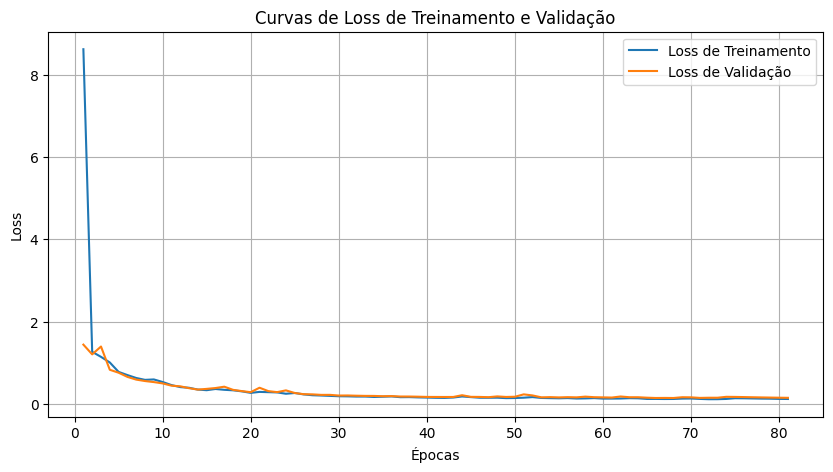

Model saved at 'models/teste1/UNSW.pth'

--- Training model: UNSW - Weight Exit 1: 1; Weight Exit 2: 0
Epoch [1/500], Train Loss: 0.6579, Validation Loss: 0.6242
Epoch [2/500], Train Loss: 0.5939, Validation Loss: 0.5677
Epoch [3/500], Train Loss: 0.5327, Validation Loss: 0.5059
Epoch [4/500], Train Loss: 0.4767, Validation Loss: 0.4544
Epoch [5/500], Train Loss: 0.4283, Validation Loss: 0.4121
Epoch [6/500], Train Loss: 0.3857, Validation Loss: 0.3730
Epoch [7/500], Train Loss: 0.3459, Validation Loss: 0.3357
Epoch [8/500], Train Loss: 0.3124, Validation Loss: 0.3061
Epoch [9/500], Train Loss: 0.2854, Validation Loss: 0.2817
Epoch [10/500], Train Loss: 0.2636, Validation Loss: 0.2637
Epoch [11/500], Train Loss: 0.2460, Validation Loss: 0.2471
Epoch [12/500], Train Loss: 0.2319, Validation Loss: 0.2387
Epoch [13/500], Train Loss: 0.2201, Validation Loss: 0.2247
Epoch [14/500], Train Loss: 0.2104, Validation Loss: 0.2165
Epoch [15/500], Train Loss: 0.2017, Validation Loss: 0.2081
Epoch 

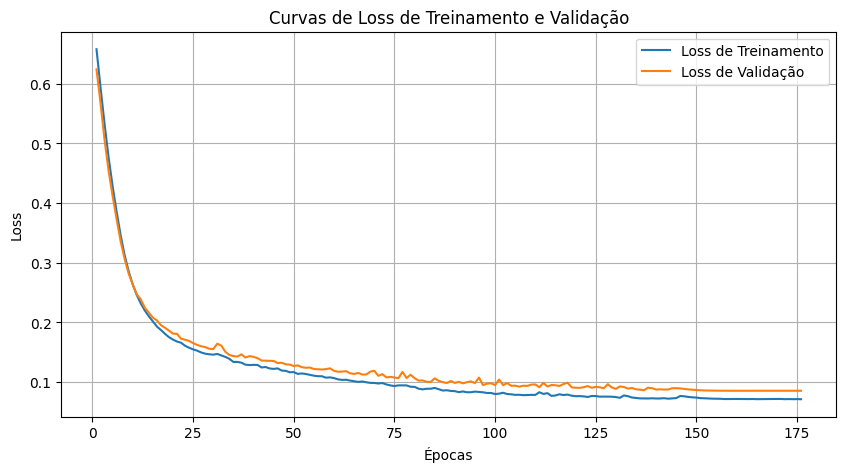

Model saved at 'models/teste2/UNSW.pth'

--- Training model: UNSW - Weight Exit 1: 0; Weight Exit 2: 1
Epoch [1/500], Train Loss: 4.3819, Validation Loss: 0.6328
Epoch [2/500], Train Loss: 0.6345, Validation Loss: 0.6118
Epoch [3/500], Train Loss: 0.5020, Validation Loss: 0.3816
Epoch [4/500], Train Loss: 0.3552, Validation Loss: 0.2699
Epoch [5/500], Train Loss: 0.3087, Validation Loss: 0.3202
Epoch [6/500], Train Loss: 0.2658, Validation Loss: 0.2528
Epoch [7/500], Train Loss: 0.2260, Validation Loss: 0.2298
Epoch [8/500], Train Loss: 0.2078, Validation Loss: 0.2316
Epoch [9/500], Train Loss: 0.1846, Validation Loss: 0.1983
Epoch [10/500], Train Loss: 0.1708, Validation Loss: 0.1316
Epoch [11/500], Train Loss: 0.1334, Validation Loss: 0.1155
Epoch [12/500], Train Loss: 0.1152, Validation Loss: 0.1652
Epoch [13/500], Train Loss: 0.2106, Validation Loss: 0.1157
Epoch [14/500], Train Loss: 0.0941, Validation Loss: 0.0929
Epoch [15/500], Train Loss: 0.1440, Validation Loss: 0.1908
Epoch 

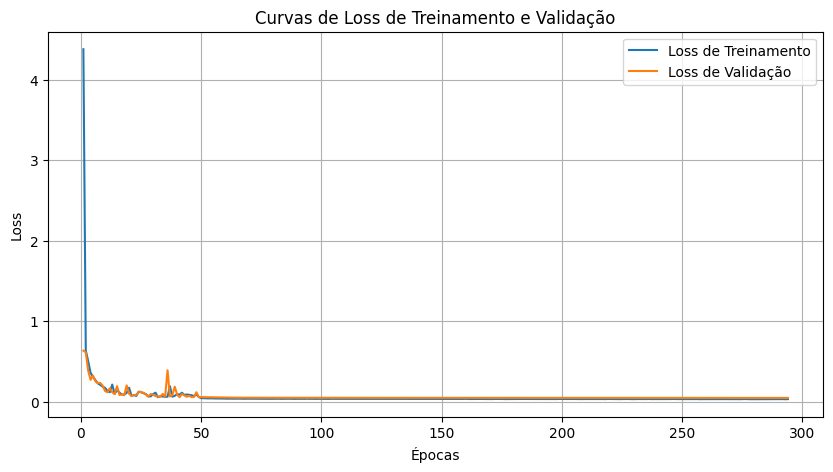

Model saved at 'models/teste3/UNSW.pth'

--- Training model: BOT - Weight Exit 1: 1; Weight Exit 2: 1
Epoch [1/500], Train Loss: 10.0315, Validation Loss: 1.3747
Epoch [2/500], Train Loss: 1.5158, Validation Loss: 1.3394
Epoch [3/500], Train Loss: 1.3209, Validation Loss: 1.2141
Epoch [4/500], Train Loss: 1.1966, Validation Loss: 1.1313
Epoch [5/500], Train Loss: 1.0935, Validation Loss: 1.0408
Epoch [6/500], Train Loss: 1.0268, Validation Loss: 0.9894
Epoch [7/500], Train Loss: 0.9963, Validation Loss: 0.9689
Epoch [8/500], Train Loss: 0.9593, Validation Loss: 0.9124
Epoch [9/500], Train Loss: 0.9378, Validation Loss: 0.8914
Epoch [10/500], Train Loss: 0.8864, Validation Loss: 0.8725
Epoch [11/500], Train Loss: 0.8613, Validation Loss: 0.8525
Epoch [12/500], Train Loss: 0.8483, Validation Loss: 0.8397
Epoch [13/500], Train Loss: 0.8377, Validation Loss: 0.8304
Epoch [14/500], Train Loss: 0.8286, Validation Loss: 0.8214
Epoch [15/500], Train Loss: 0.8206, Validation Loss: 0.8142
Epoch 

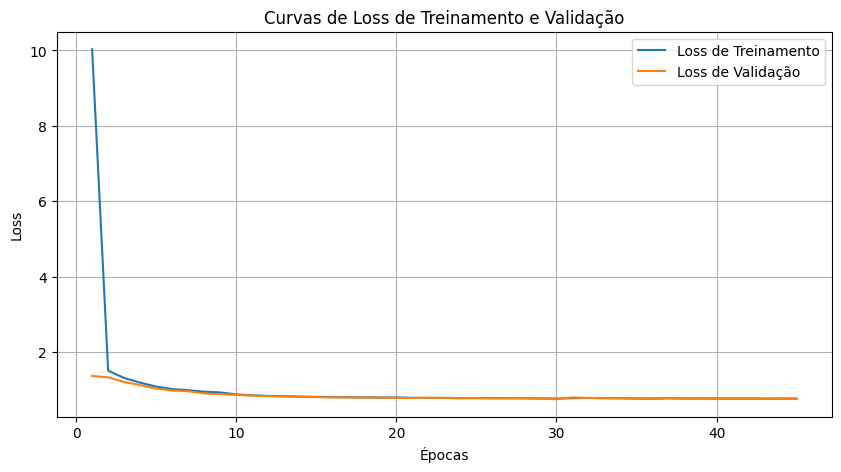

Model saved at 'models/teste1/BOT.pth'

--- Training model: BOT - Weight Exit 1: 1; Weight Exit 2: 0
Epoch [1/500], Train Loss: 0.6850, Validation Loss: 0.6678
Epoch [2/500], Train Loss: 0.6542, Validation Loss: 0.6284
Epoch [3/500], Train Loss: 0.6117, Validation Loss: 0.5807
Epoch [4/500], Train Loss: 0.5664, Validation Loss: 0.5386
Epoch [5/500], Train Loss: 0.5289, Validation Loss: 0.5077
Epoch [6/500], Train Loss: 0.5025, Validation Loss: 0.4865
Epoch [7/500], Train Loss: 0.4832, Validation Loss: 0.4707
Epoch [8/500], Train Loss: 0.4675, Validation Loss: 0.4575
Epoch [9/500], Train Loss: 0.4544, Validation Loss: 0.4461
Epoch [10/500], Train Loss: 0.4439, Validation Loss: 0.4366
Epoch [11/500], Train Loss: 0.4353, Validation Loss: 0.4293
Epoch [12/500], Train Loss: 0.4284, Validation Loss: 0.4224
Epoch [13/500], Train Loss: 0.4221, Validation Loss: 0.4174
Epoch [14/500], Train Loss: 0.4174, Validation Loss: 0.4132
Epoch [15/500], Train Loss: 0.4136, Validation Loss: 0.4105
Epoch [1

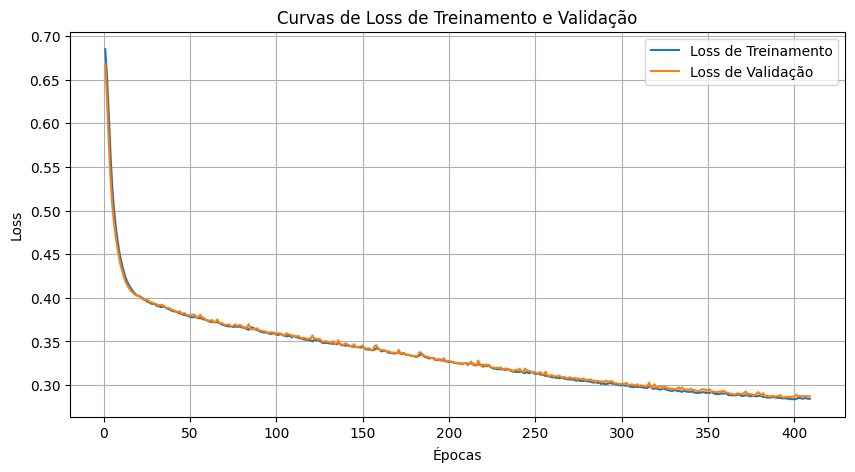

Model saved at 'models/teste2/BOT.pth'

--- Training model: BOT - Weight Exit 1: 0; Weight Exit 2: 1
Epoch [1/500], Train Loss: 6.2985, Validation Loss: 0.7038
Epoch [2/500], Train Loss: 0.8150, Validation Loss: 0.6009
Epoch [3/500], Train Loss: 0.5946, Validation Loss: 0.5123
Epoch [4/500], Train Loss: 0.5250, Validation Loss: 0.4747
Epoch [5/500], Train Loss: 0.4529, Validation Loss: 0.5993
Epoch [6/500], Train Loss: 0.4960, Validation Loss: 0.4065
Epoch [7/500], Train Loss: 0.4531, Validation Loss: 0.4054
Epoch [8/500], Train Loss: 0.4150, Validation Loss: 0.4104
Epoch [9/500], Train Loss: 0.4080, Validation Loss: 0.4002
Epoch [10/500], Train Loss: 0.4000, Validation Loss: 0.3936
Epoch [11/500], Train Loss: 0.3930, Validation Loss: 0.3919
Epoch [12/500], Train Loss: 0.3936, Validation Loss: 0.3910
Epoch [13/500], Train Loss: 0.3896, Validation Loss: 0.3923
Epoch [14/500], Train Loss: 0.3885, Validation Loss: 0.3906
Epoch [15/500], Train Loss: 0.3908, Validation Loss: 0.3918
Epoch [1

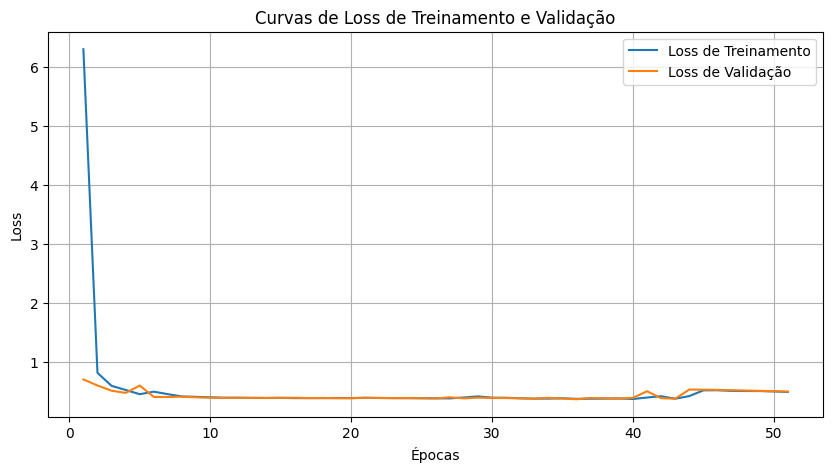

Model saved at 'models/teste3/BOT.pth'

--- Training model: CIC - Weight Exit 1: 1; Weight Exit 2: 1
Epoch [1/500], Train Loss: 3.7190, Validation Loss: 1.1626
Epoch [2/500], Train Loss: 1.0477, Validation Loss: 0.9663
Epoch [3/500], Train Loss: 0.8946, Validation Loss: 0.8127
Epoch [4/500], Train Loss: 0.7785, Validation Loss: 0.7325
Epoch [5/500], Train Loss: 0.7190, Validation Loss: 0.6879
Epoch [6/500], Train Loss: 0.7075, Validation Loss: 0.6858
Epoch [7/500], Train Loss: 0.6582, Validation Loss: 0.6484
Epoch [8/500], Train Loss: 0.6275, Validation Loss: 0.5969
Epoch [9/500], Train Loss: 0.5909, Validation Loss: 0.5738
Epoch [10/500], Train Loss: 0.5775, Validation Loss: 0.5670
Epoch [11/500], Train Loss: 0.5667, Validation Loss: 0.5483
Epoch [12/500], Train Loss: 0.5450, Validation Loss: 0.5288
Epoch [13/500], Train Loss: 0.5219, Validation Loss: 0.5103
Epoch [14/500], Train Loss: 0.5022, Validation Loss: 0.4975
Epoch [15/500], Train Loss: 0.4886, Validation Loss: 0.4856
Epoch [1

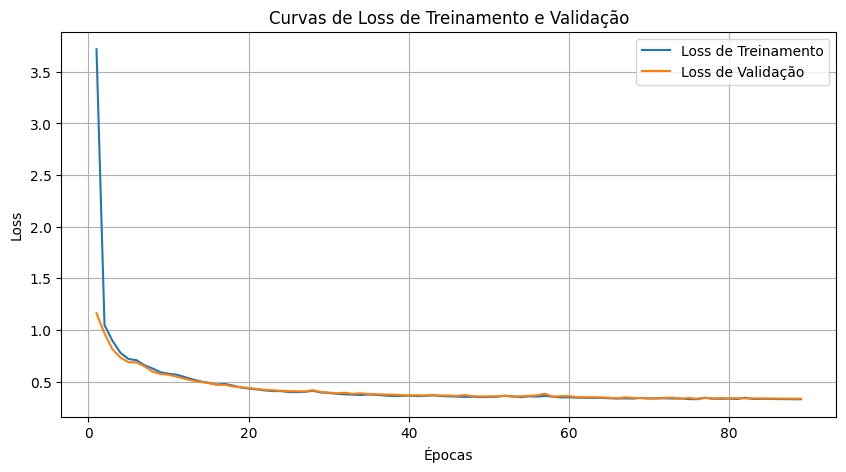

Model saved at 'models/teste1/CIC.pth'

--- Training model: CIC - Weight Exit 1: 1; Weight Exit 2: 0
Epoch [1/500], Train Loss: 0.6248, Validation Loss: 0.5534
Epoch [2/500], Train Loss: 0.5123, Validation Loss: 0.4778
Epoch [3/500], Train Loss: 0.4520, Validation Loss: 0.4322
Epoch [4/500], Train Loss: 0.4203, Validation Loss: 0.4150
Epoch [5/500], Train Loss: 0.4050, Validation Loss: 0.4000
Epoch [6/500], Train Loss: 0.3883, Validation Loss: 0.3873
Epoch [7/500], Train Loss: 0.3742, Validation Loss: 0.3743
Epoch [8/500], Train Loss: 0.3582, Validation Loss: 0.3593
Epoch [9/500], Train Loss: 0.3427, Validation Loss: 0.3484
Epoch [10/500], Train Loss: 0.3308, Validation Loss: 0.3359
Epoch [11/500], Train Loss: 0.3167, Validation Loss: 0.3241
Epoch [12/500], Train Loss: 0.3073, Validation Loss: 0.3158
Epoch [13/500], Train Loss: 0.2966, Validation Loss: 0.3065
Epoch [14/500], Train Loss: 0.2879, Validation Loss: 0.2987
Epoch [15/500], Train Loss: 0.2806, Validation Loss: 0.2928
Epoch [1

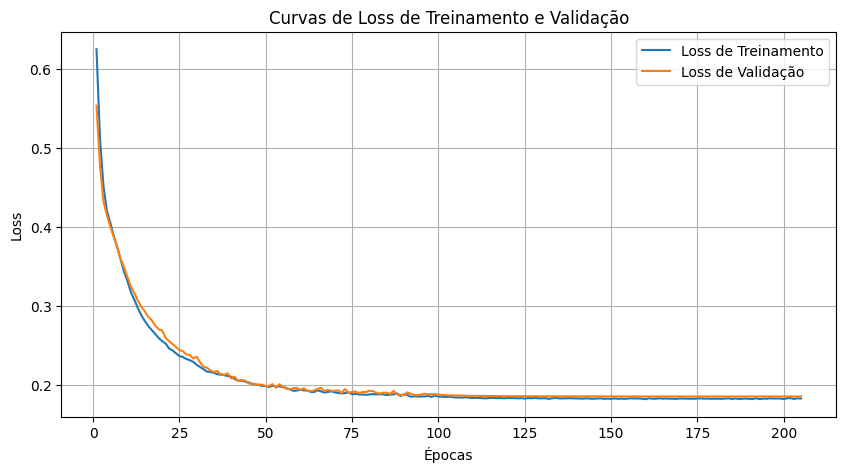

Model saved at 'models/teste2/CIC.pth'

--- Training model: CIC - Weight Exit 1: 0; Weight Exit 2: 1
Epoch [1/500], Train Loss: 3.1034, Validation Loss: 0.6551
Epoch [2/500], Train Loss: 0.5875, Validation Loss: 0.5613
Epoch [3/500], Train Loss: 0.4920, Validation Loss: 0.4487
Epoch [4/500], Train Loss: 0.4107, Validation Loss: 0.3746
Epoch [5/500], Train Loss: 0.3541, Validation Loss: 0.3178
Epoch [6/500], Train Loss: 0.3460, Validation Loss: 0.3843
Epoch [7/500], Train Loss: 0.3194, Validation Loss: 0.2676
Epoch [8/500], Train Loss: 0.2645, Validation Loss: 0.2981
Epoch [9/500], Train Loss: 0.2807, Validation Loss: 0.2398
Epoch [10/500], Train Loss: 0.2373, Validation Loss: 0.2131
Epoch [11/500], Train Loss: 0.2146, Validation Loss: 0.2278
Epoch [12/500], Train Loss: 0.2054, Validation Loss: 0.2046
Epoch [13/500], Train Loss: 0.1934, Validation Loss: 0.1958
Epoch [14/500], Train Loss: 0.1823, Validation Loss: 0.1778
Epoch [15/500], Train Loss: 0.1978, Validation Loss: 0.1986
Epoch [1

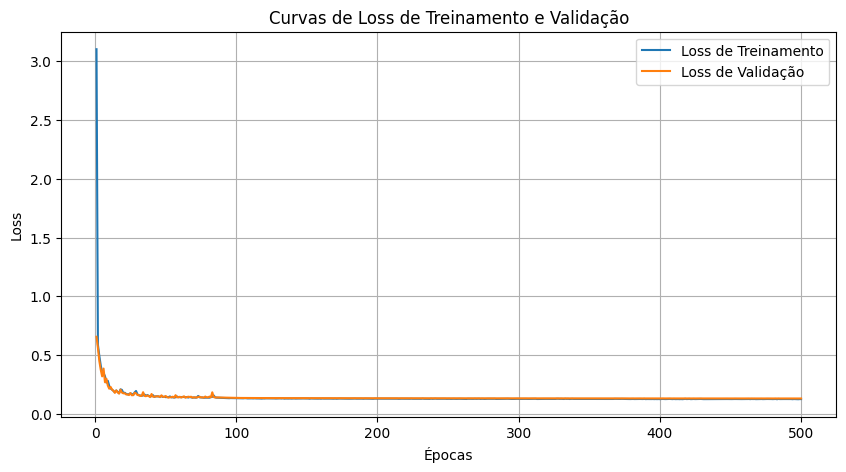

Model saved at 'models/teste3/CIC.pth'



In [18]:
epochs = 500

for model_id in range(len(model_names)):
    for test in test_ids:
        model = IDSBranchyNet()
        
        if test == 1:
            weight1 = 1
            weight2 = 1
        elif test == 2:
            weight1 = 1
            weight2 = 0
        elif test == 3:
            weight1 = 0
            weight2 = 1
        
            
        print(f"--- Training model: {model_names[model_id]} - Weight Exit 1: {weight1}; Weight Exit 2: {weight2}")
        
        train_losses, val_losses = train_model(model, train_loaders[model_id], val_loaders[model_id], epochs, weight1, weight2, 0.01, device=device, modelname=model_names[model_id], test=test)

        torch.save(model.state_dict(), f'models/teste{test}/{model_names[model_id]}.pth')
        print(f"Model saved at 'models/teste{test}/{model_names[model_id]}.pth'\n")
        

--- Model: UNSW | Loader: UNSW | TestID: 1 | Threshold: 0.7 ---
Model from: 'models/teste1/UNSW.pth' carregado


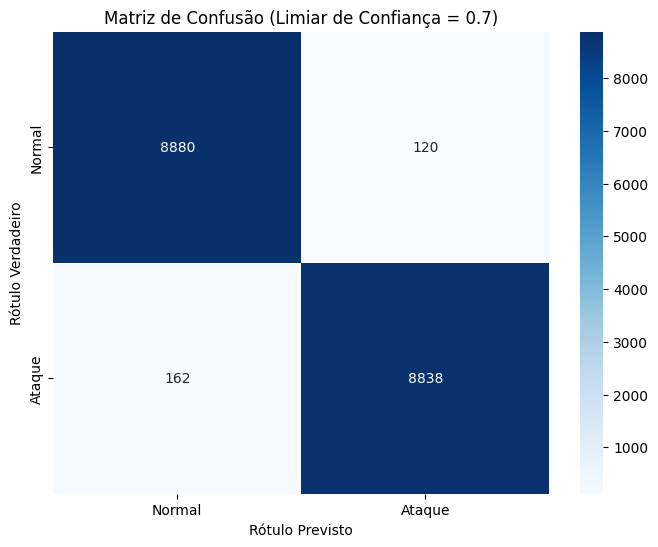

True Positives (TP): 8838
True Negatives (TN): 8880
False Positives (FP): 120
False Negatives (FN): 162

F1 Score: 0.9843
True Positive Rate (TPR) / Recall: 0.9820
True Negative Rate (TNR) / Specificity: 0.9867
--------------------
Threshold: 0.7
  Accuracy: 98.43%
  Avg. Inference Time: 0.0016 ms
  Early Exit Rate: 94.75% (17055/18000)
--------------------


--- Model: UNSW | Loader: UNSW | TestID: 2 | Threshold: 0 ---
Model from: 'models/teste2/UNSW.pth' carregado


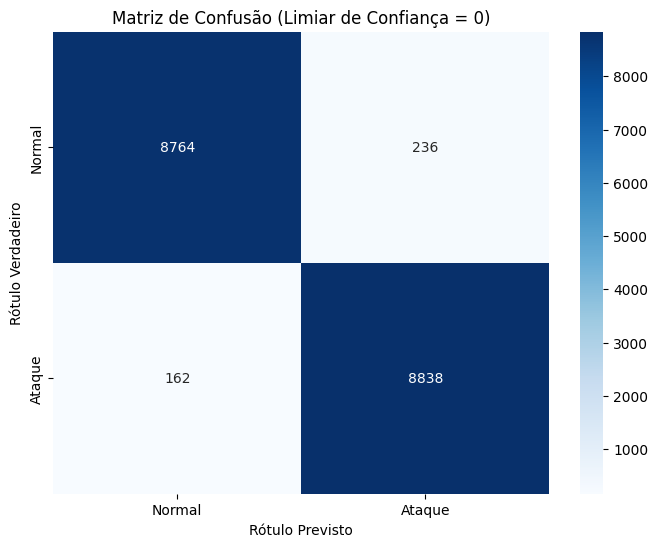

True Positives (TP): 8838
True Negatives (TN): 8764
False Positives (FP): 236
False Negatives (FN): 162

F1 Score: 0.9780
True Positive Rate (TPR) / Recall: 0.9820
True Negative Rate (TNR) / Specificity: 0.9738
--------------------
Threshold: 0
  Accuracy: 97.79%
  Avg. Inference Time: 0.0006 ms
  Early Exit Rate: 100.00% (18000/18000)
--------------------


--- Model: UNSW | Loader: UNSW | TestID: 3 | Threshold: 2 ---
Model from: 'models/teste3/UNSW.pth' carregado


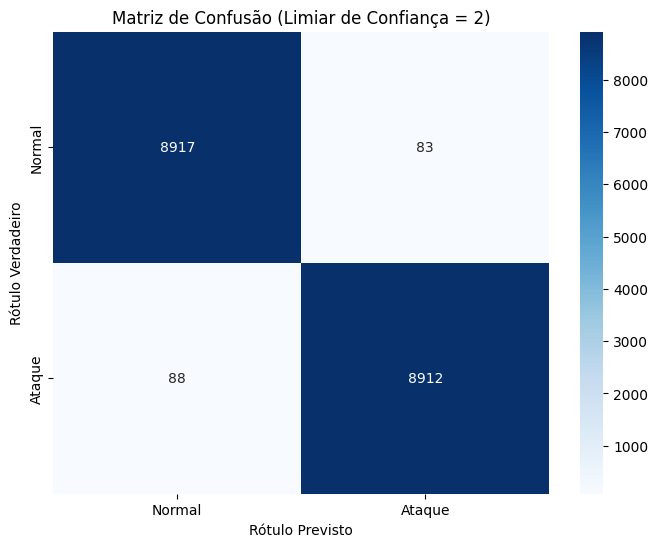

True Positives (TP): 8912
True Negatives (TN): 8917
False Positives (FP): 83
False Negatives (FN): 88

F1 Score: 0.9905
True Positive Rate (TPR) / Recall: 0.9902
True Negative Rate (TNR) / Specificity: 0.9908
--------------------
Threshold: 2
  Accuracy: 99.05%
  Avg. Inference Time: 0.0023 ms
  Early Exit Rate: 0.00% (0/18000)
--------------------


--- Model: UNSW | Loader: BOT | TestID: 1 | Threshold: 0.7 ---
Model from: 'models/teste1/UNSW.pth' carregado


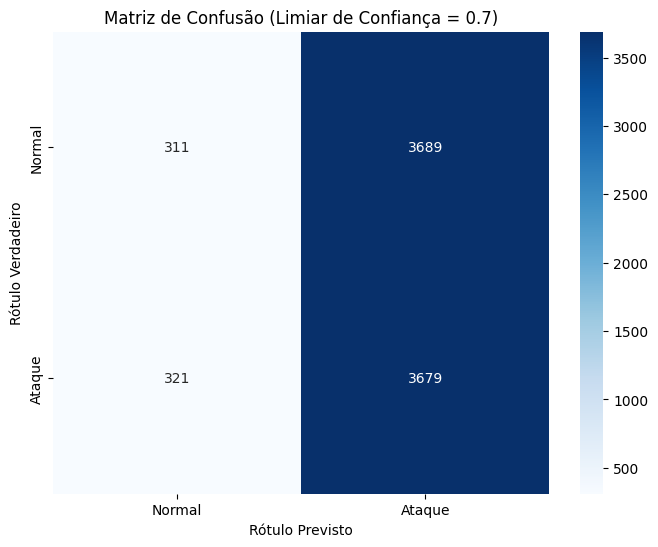

True Positives (TP): 3679
True Negatives (TN): 311
False Positives (FP): 3689
False Negatives (FN): 321

F1 Score: 0.6473
True Positive Rate (TPR) / Recall: 0.9197
True Negative Rate (TNR) / Specificity: 0.0777
--------------------
Threshold: 0.7
  Accuracy: 49.88%
  Avg. Inference Time: 0.0025 ms
  Early Exit Rate: 58.06% (4645/8000)
--------------------


--- Model: UNSW | Loader: BOT | TestID: 2 | Threshold: 0 ---
Model from: 'models/teste2/UNSW.pth' carregado


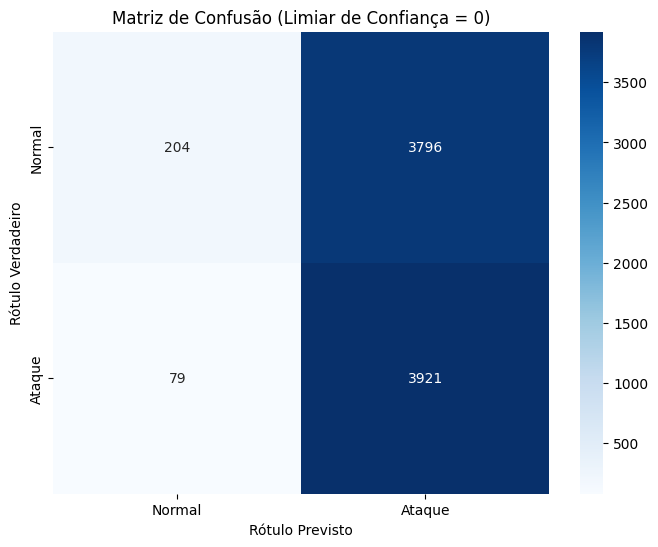

True Positives (TP): 3921
True Negatives (TN): 204
False Positives (FP): 3796
False Negatives (FN): 79

F1 Score: 0.6693
True Positive Rate (TPR) / Recall: 0.9802
True Negative Rate (TNR) / Specificity: 0.0510
--------------------
Threshold: 0
  Accuracy: 51.56%
  Avg. Inference Time: 0.0007 ms
  Early Exit Rate: 100.00% (8000/8000)
--------------------


--- Model: UNSW | Loader: BOT | TestID: 3 | Threshold: 2 ---
Model from: 'models/teste3/UNSW.pth' carregado


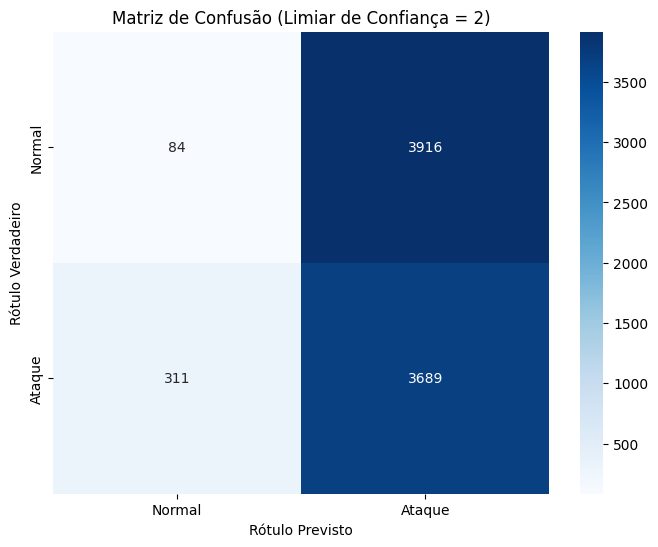

True Positives (TP): 3689
True Negatives (TN): 84
False Positives (FP): 3916
False Negatives (FN): 311

F1 Score: 0.6358
True Positive Rate (TPR) / Recall: 0.9223
True Negative Rate (TNR) / Specificity: 0.0210
--------------------
Threshold: 2
  Accuracy: 47.16%
  Avg. Inference Time: 0.0025 ms
  Early Exit Rate: 0.00% (0/8000)
--------------------


--- Model: UNSW | Loader: CIC | TestID: 1 | Threshold: 0.7 ---
Model from: 'models/teste1/UNSW.pth' carregado


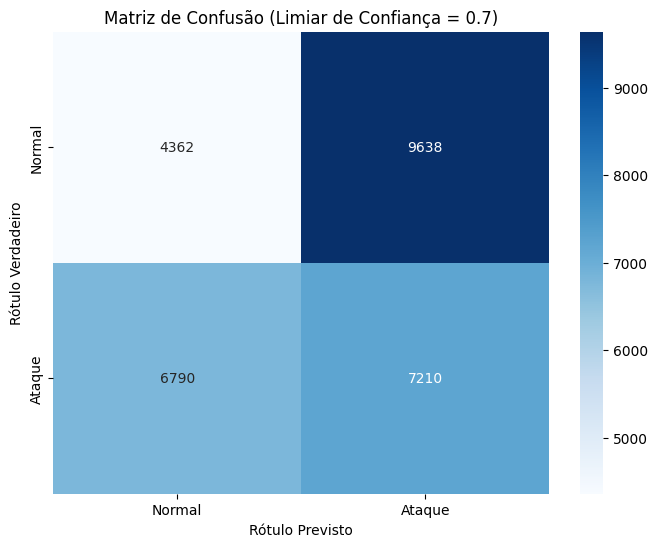

True Positives (TP): 7210
True Negatives (TN): 4362
False Positives (FP): 9638
False Negatives (FN): 6790

F1 Score: 0.4675
True Positive Rate (TPR) / Recall: 0.5150
True Negative Rate (TNR) / Specificity: 0.3116
--------------------
Threshold: 0.7
  Accuracy: 41.33%
  Avg. Inference Time: 0.0014 ms
  Early Exit Rate: 83.27% (23316/28000)
--------------------


--- Model: UNSW | Loader: CIC | TestID: 2 | Threshold: 0 ---
Model from: 'models/teste2/UNSW.pth' carregado


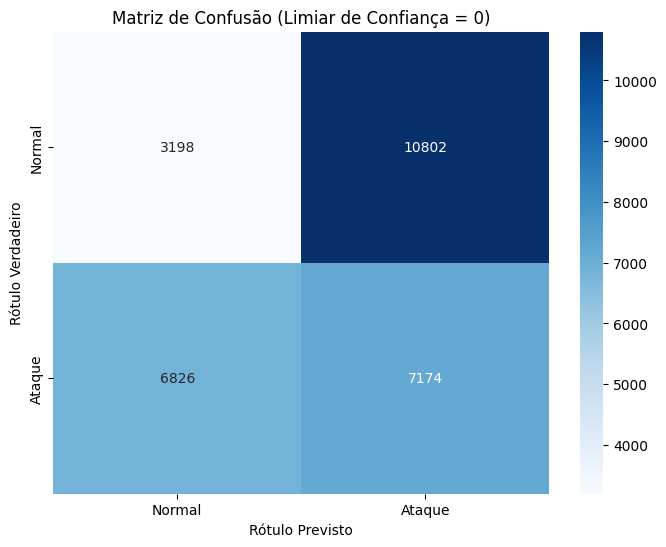

True Positives (TP): 7174
True Negatives (TN): 3198
False Positives (FP): 10802
False Negatives (FN): 6826

F1 Score: 0.4487
True Positive Rate (TPR) / Recall: 0.5124
True Negative Rate (TNR) / Specificity: 0.2284
--------------------
Threshold: 0
  Accuracy: 37.04%
  Avg. Inference Time: 0.0009 ms
  Early Exit Rate: 100.00% (28000/28000)
--------------------


--- Model: UNSW | Loader: CIC | TestID: 3 | Threshold: 2 ---
Model from: 'models/teste3/UNSW.pth' carregado


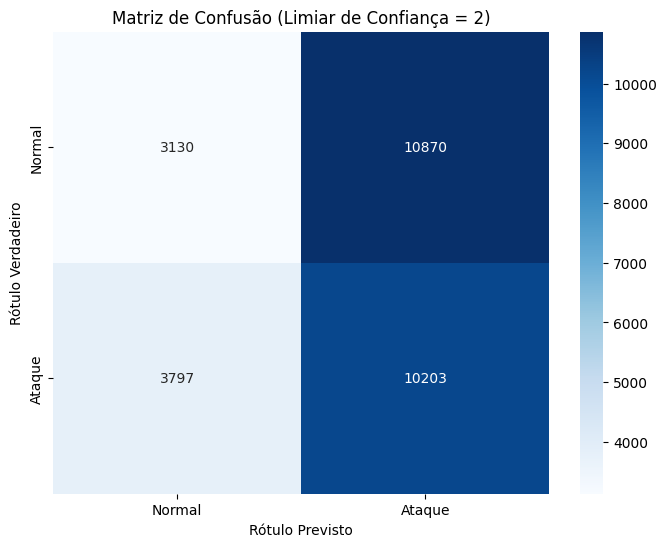

True Positives (TP): 10203
True Negatives (TN): 3130
False Positives (FP): 10870
False Negatives (FN): 3797

F1 Score: 0.5818
True Positive Rate (TPR) / Recall: 0.7288
True Negative Rate (TNR) / Specificity: 0.2236
--------------------
Threshold: 2
  Accuracy: 47.62%
  Avg. Inference Time: 0.0024 ms
  Early Exit Rate: 0.00% (0/28000)
--------------------


--- Model: BOT | Loader: UNSW | TestID: 1 | Threshold: 0.7 ---
Model from: 'models/teste1/BOT.pth' carregado


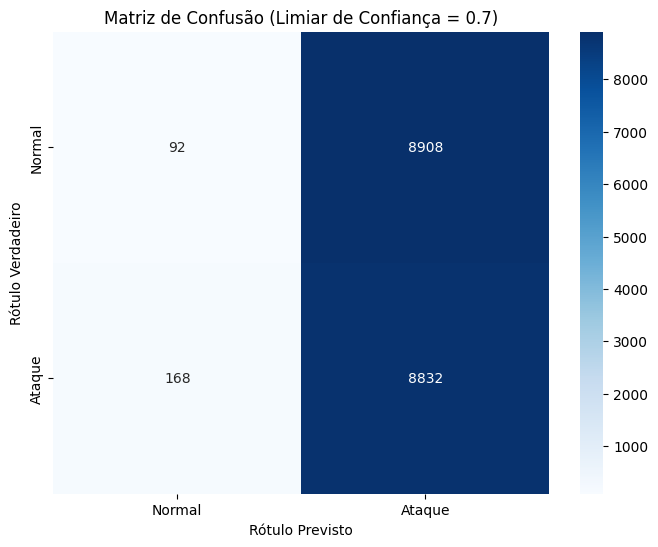

True Positives (TP): 8832
True Negatives (TN): 92
False Positives (FP): 8908
False Negatives (FN): 168

F1 Score: 0.6606
True Positive Rate (TPR) / Recall: 0.9813
True Negative Rate (TNR) / Specificity: 0.0102
--------------------
Threshold: 0.7
  Accuracy: 49.58%
  Avg. Inference Time: 0.0019 ms
  Early Exit Rate: 92.52% (16654/18000)
--------------------


--- Model: BOT | Loader: UNSW | TestID: 2 | Threshold: 0 ---
Model from: 'models/teste2/BOT.pth' carregado


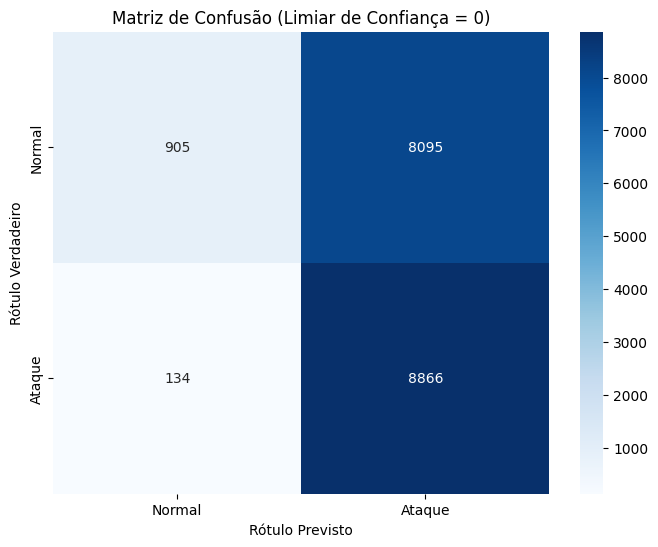

True Positives (TP): 8866
True Negatives (TN): 905
False Positives (FP): 8095
False Negatives (FN): 134

F1 Score: 0.6830
True Positive Rate (TPR) / Recall: 0.9851
True Negative Rate (TNR) / Specificity: 0.1006
--------------------
Threshold: 0
  Accuracy: 54.28%
  Avg. Inference Time: 0.0007 ms
  Early Exit Rate: 100.00% (18000/18000)
--------------------


--- Model: BOT | Loader: UNSW | TestID: 3 | Threshold: 2 ---
Model from: 'models/teste3/BOT.pth' carregado


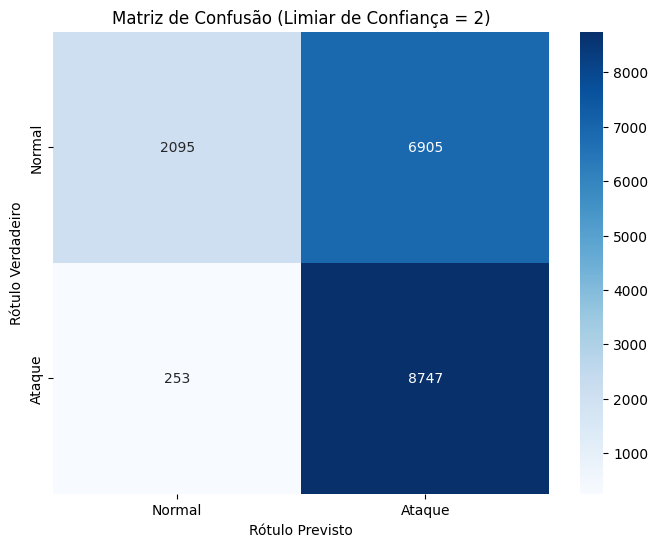

True Positives (TP): 8747
True Negatives (TN): 2095
False Positives (FP): 6905
False Negatives (FN): 253

F1 Score: 0.7096
True Positive Rate (TPR) / Recall: 0.9719
True Negative Rate (TNR) / Specificity: 0.2328
--------------------
Threshold: 2
  Accuracy: 60.23%
  Avg. Inference Time: 0.0029 ms
  Early Exit Rate: 0.00% (0/18000)
--------------------


--- Model: BOT | Loader: BOT | TestID: 1 | Threshold: 0.7 ---
Model from: 'models/teste1/BOT.pth' carregado


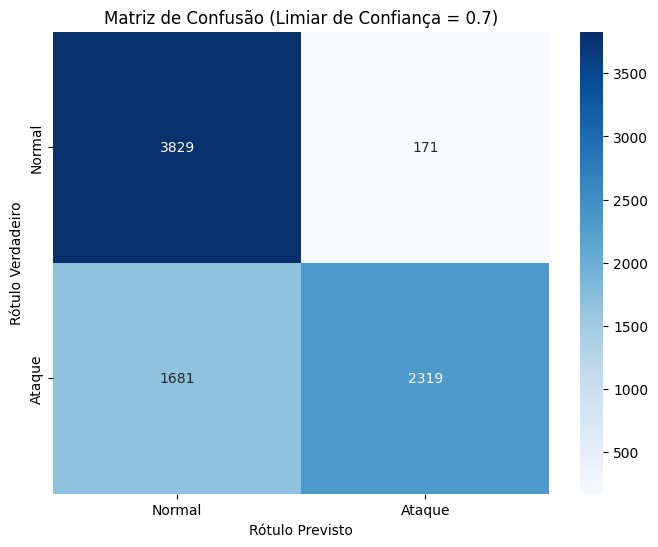

True Positives (TP): 2319
True Negatives (TN): 3829
False Positives (FP): 171
False Negatives (FN): 1681

F1 Score: 0.7146
True Positive Rate (TPR) / Recall: 0.5797
True Negative Rate (TNR) / Specificity: 0.9573
--------------------
Threshold: 0.7
  Accuracy: 76.85%
  Avg. Inference Time: 0.0022 ms
  Early Exit Rate: 47.14% (3771/8000)
--------------------


--- Model: BOT | Loader: BOT | TestID: 2 | Threshold: 0 ---
Model from: 'models/teste2/BOT.pth' carregado


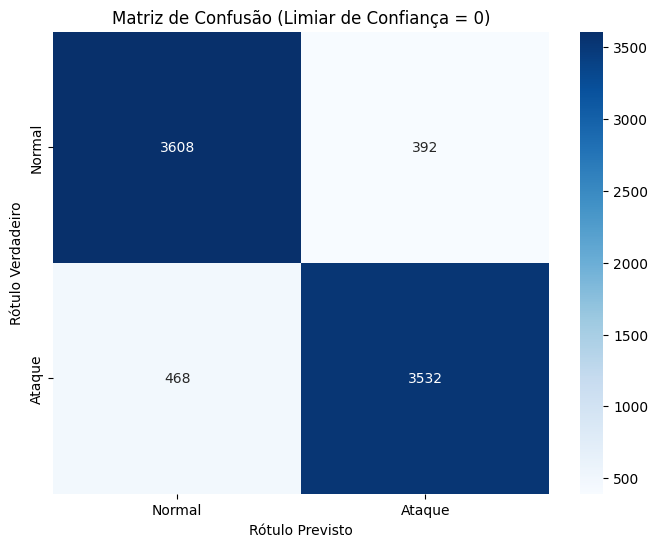

True Positives (TP): 3532
True Negatives (TN): 3608
False Positives (FP): 392
False Negatives (FN): 468

F1 Score: 0.8915
True Positive Rate (TPR) / Recall: 0.8830
True Negative Rate (TNR) / Specificity: 0.9020
--------------------
Threshold: 0
  Accuracy: 89.25%
  Avg. Inference Time: 0.0008 ms
  Early Exit Rate: 100.00% (8000/8000)
--------------------


--- Model: BOT | Loader: BOT | TestID: 3 | Threshold: 2 ---
Model from: 'models/teste3/BOT.pth' carregado


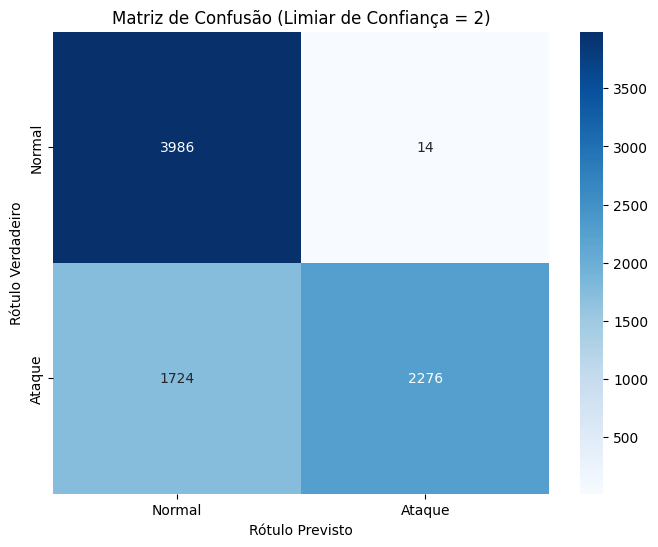

True Positives (TP): 2276
True Negatives (TN): 3986
False Positives (FP): 14
False Negatives (FN): 1724

F1 Score: 0.7237
True Positive Rate (TPR) / Recall: 0.5690
True Negative Rate (TNR) / Specificity: 0.9965
--------------------
Threshold: 2
  Accuracy: 78.28%
  Avg. Inference Time: 0.0027 ms
  Early Exit Rate: 0.00% (0/8000)
--------------------


--- Model: BOT | Loader: CIC | TestID: 1 | Threshold: 0.7 ---
Model from: 'models/teste1/BOT.pth' carregado


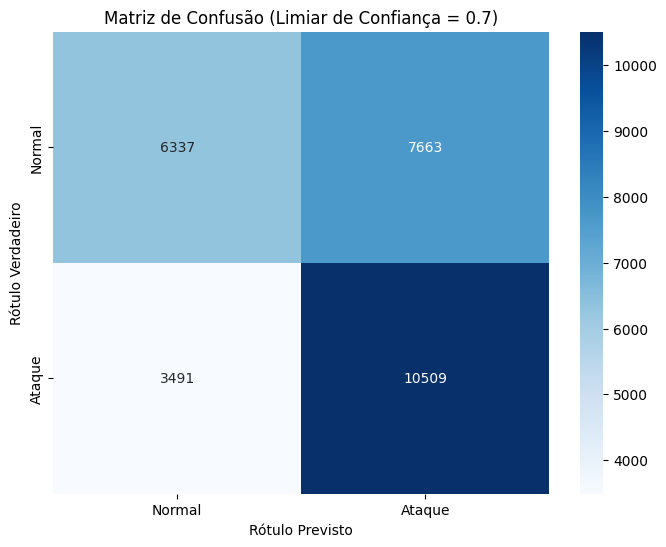

True Positives (TP): 10509
True Negatives (TN): 6337
False Positives (FP): 7663
False Negatives (FN): 3491

F1 Score: 0.6533
True Positive Rate (TPR) / Recall: 0.7506
True Negative Rate (TNR) / Specificity: 0.4526
--------------------
Threshold: 0.7
  Accuracy: 60.16%
  Avg. Inference Time: 0.0017 ms
  Early Exit Rate: 75.17% (21049/28000)
--------------------


--- Model: BOT | Loader: CIC | TestID: 2 | Threshold: 0 ---
Model from: 'models/teste2/BOT.pth' carregado


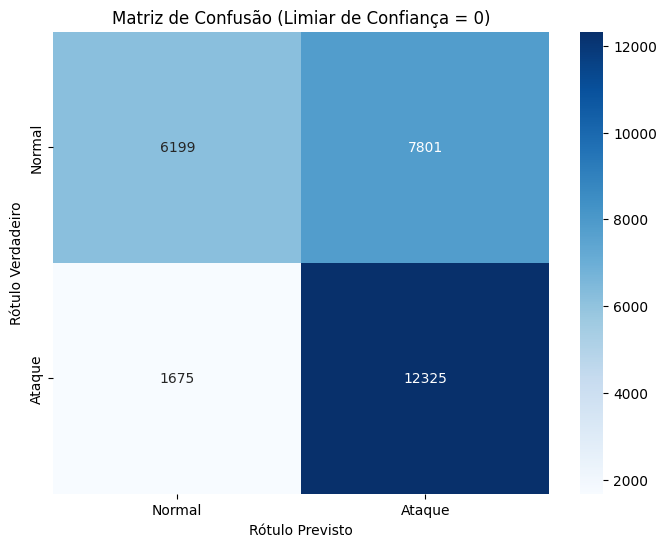

True Positives (TP): 12325
True Negatives (TN): 6199
False Positives (FP): 7801
False Negatives (FN): 1675

F1 Score: 0.7223
True Positive Rate (TPR) / Recall: 0.8804
True Negative Rate (TNR) / Specificity: 0.4428
--------------------
Threshold: 0
  Accuracy: 66.16%
  Avg. Inference Time: 0.0008 ms
  Early Exit Rate: 100.00% (28000/28000)
--------------------


--- Model: BOT | Loader: CIC | TestID: 3 | Threshold: 2 ---
Model from: 'models/teste3/BOT.pth' carregado


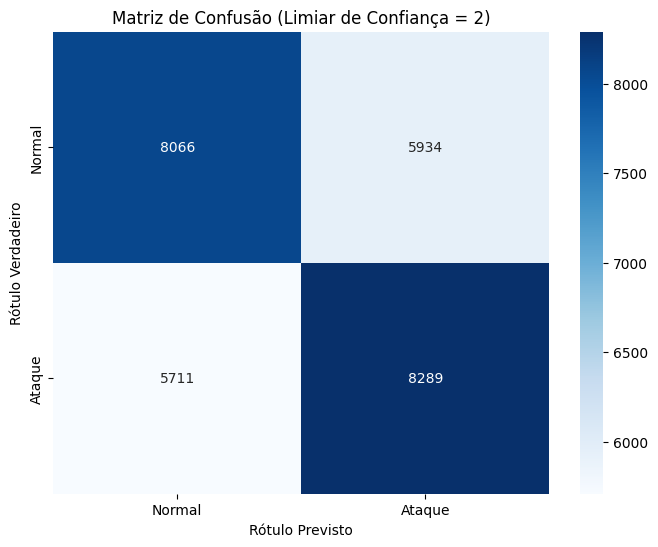

True Positives (TP): 8289
True Negatives (TN): 8066
False Positives (FP): 5934
False Negatives (FN): 5711

F1 Score: 0.5874
True Positive Rate (TPR) / Recall: 0.5921
True Negative Rate (TNR) / Specificity: 0.5761
--------------------
Threshold: 2
  Accuracy: 58.41%
  Avg. Inference Time: 0.0023 ms
  Early Exit Rate: 0.00% (0/28000)
--------------------


--- Model: CIC | Loader: UNSW | TestID: 1 | Threshold: 0.7 ---
Model from: 'models/teste1/CIC.pth' carregado


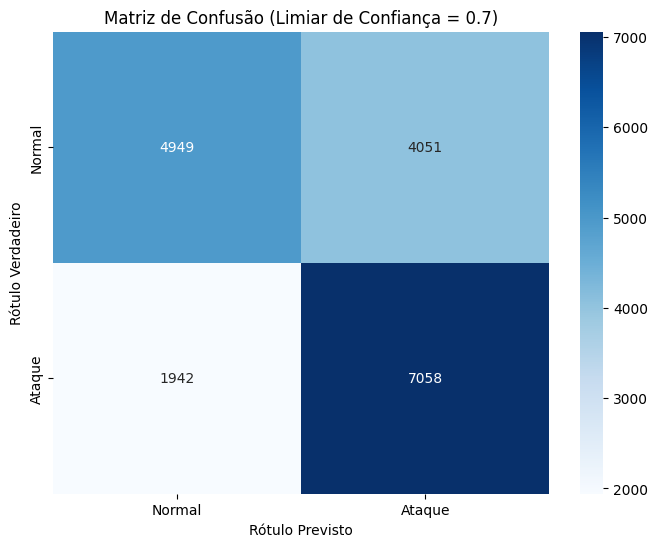

True Positives (TP): 7058
True Negatives (TN): 4949
False Positives (FP): 4051
False Negatives (FN): 1942

F1 Score: 0.7020
True Positive Rate (TPR) / Recall: 0.7842
True Negative Rate (TNR) / Specificity: 0.5499
--------------------
Threshold: 0.7
  Accuracy: 66.71%
  Avg. Inference Time: 0.0015 ms
  Early Exit Rate: 77.02% (13864/18000)
--------------------


--- Model: CIC | Loader: UNSW | TestID: 2 | Threshold: 0 ---
Model from: 'models/teste2/CIC.pth' carregado


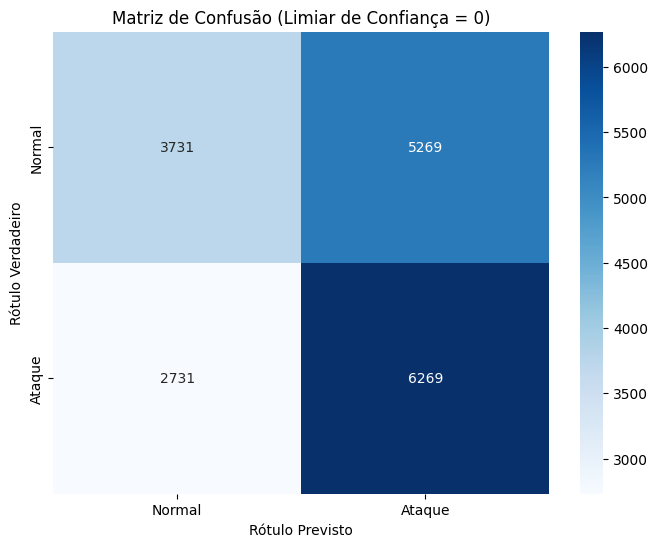

True Positives (TP): 6269
True Negatives (TN): 3731
False Positives (FP): 5269
False Negatives (FN): 2731

F1 Score: 0.6105
True Positive Rate (TPR) / Recall: 0.6966
True Negative Rate (TNR) / Specificity: 0.4146
--------------------
Threshold: 0
  Accuracy: 55.56%
  Avg. Inference Time: 0.0007 ms
  Early Exit Rate: 100.00% (18000/18000)
--------------------


--- Model: CIC | Loader: UNSW | TestID: 3 | Threshold: 2 ---
Model from: 'models/teste3/CIC.pth' carregado


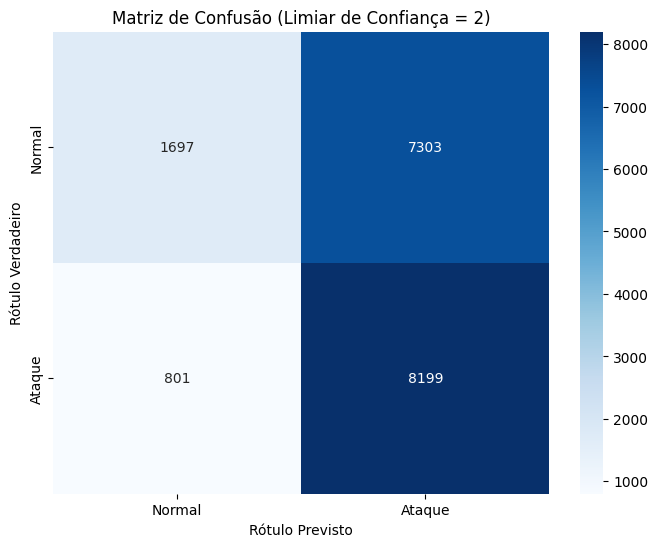

True Positives (TP): 8199
True Negatives (TN): 1697
False Positives (FP): 7303
False Negatives (FN): 801

F1 Score: 0.6693
True Positive Rate (TPR) / Recall: 0.9110
True Negative Rate (TNR) / Specificity: 0.1886
--------------------
Threshold: 2
  Accuracy: 54.98%
  Avg. Inference Time: 0.0023 ms
  Early Exit Rate: 0.00% (0/18000)
--------------------


--- Model: CIC | Loader: BOT | TestID: 1 | Threshold: 0.7 ---
Model from: 'models/teste1/CIC.pth' carregado


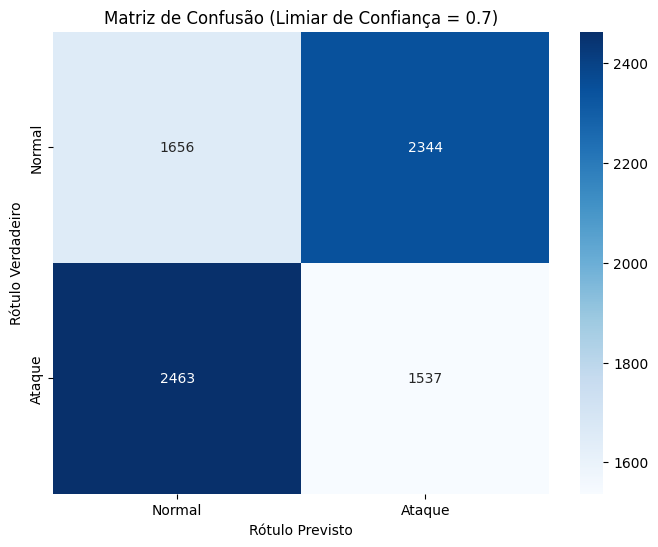

True Positives (TP): 1537
True Negatives (TN): 1656
False Positives (FP): 2344
False Negatives (FN): 2463

F1 Score: 0.3901
True Positive Rate (TPR) / Recall: 0.3842
True Negative Rate (TNR) / Specificity: 0.4140
--------------------
Threshold: 0.7
  Accuracy: 39.91%
  Avg. Inference Time: 0.0016 ms
  Early Exit Rate: 84.46% (6757/8000)
--------------------


--- Model: CIC | Loader: BOT | TestID: 2 | Threshold: 0 ---
Model from: 'models/teste2/CIC.pth' carregado


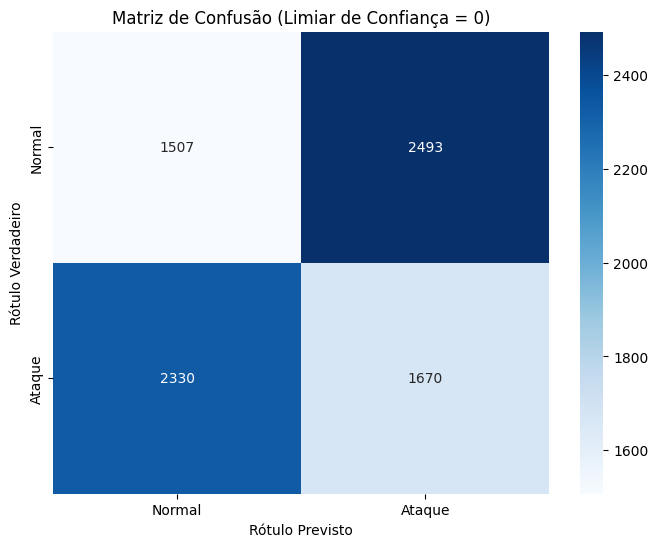

True Positives (TP): 1670
True Negatives (TN): 1507
False Positives (FP): 2493
False Negatives (FN): 2330

F1 Score: 0.4092
True Positive Rate (TPR) / Recall: 0.4175
True Negative Rate (TNR) / Specificity: 0.3767
--------------------
Threshold: 0
  Accuracy: 39.71%
  Avg. Inference Time: 0.0007 ms
  Early Exit Rate: 100.00% (8000/8000)
--------------------


--- Model: CIC | Loader: BOT | TestID: 3 | Threshold: 2 ---
Model from: 'models/teste3/CIC.pth' carregado


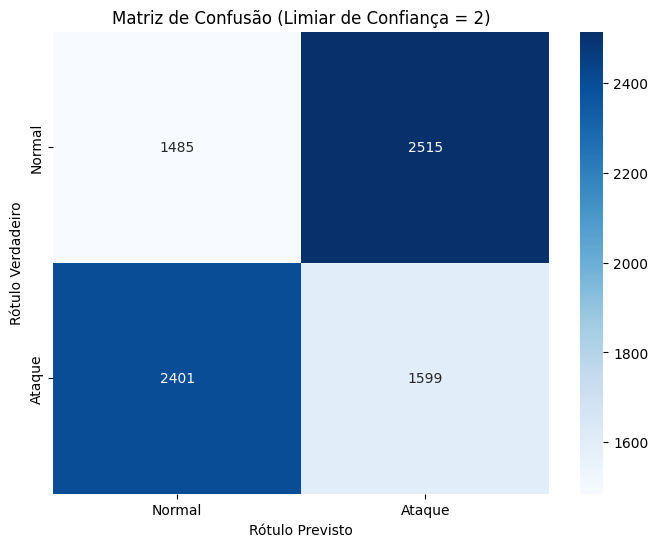

True Positives (TP): 1599
True Negatives (TN): 1485
False Positives (FP): 2515
False Negatives (FN): 2401

F1 Score: 0.3941
True Positive Rate (TPR) / Recall: 0.3997
True Negative Rate (TNR) / Specificity: 0.3713
--------------------
Threshold: 2
  Accuracy: 38.55%
  Avg. Inference Time: 0.0024 ms
  Early Exit Rate: 0.00% (0/8000)
--------------------


--- Model: CIC | Loader: CIC | TestID: 1 | Threshold: 0.7 ---
Model from: 'models/teste1/CIC.pth' carregado


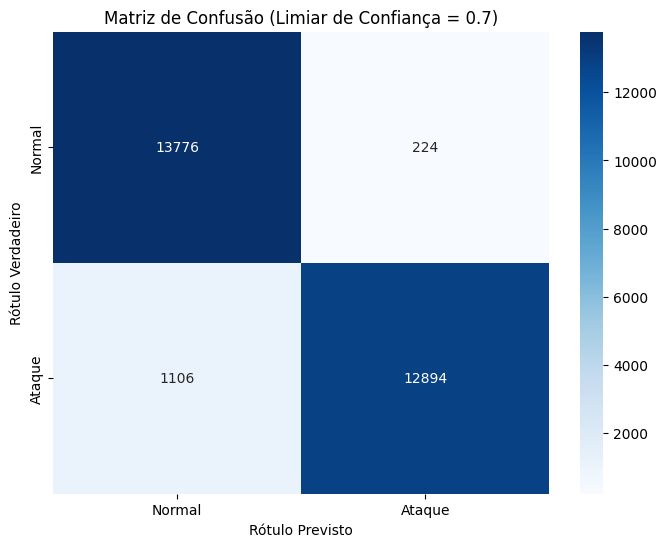

True Positives (TP): 12894
True Negatives (TN): 13776
False Positives (FP): 224
False Negatives (FN): 1106

F1 Score: 0.9510
True Positive Rate (TPR) / Recall: 0.9210
True Negative Rate (TNR) / Specificity: 0.9840
--------------------
Threshold: 0.7
  Accuracy: 95.25%
  Avg. Inference Time: 0.0019 ms
  Early Exit Rate: 97.20% (27217/28000)
--------------------


--- Model: CIC | Loader: CIC | TestID: 2 | Threshold: 0 ---
Model from: 'models/teste2/CIC.pth' carregado


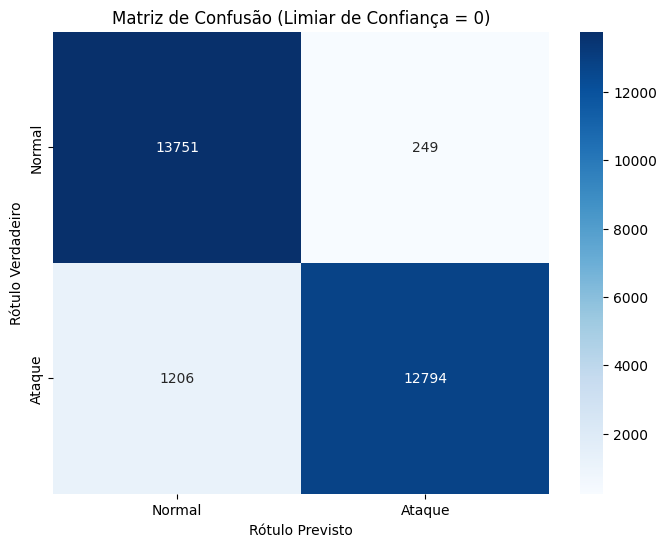

True Positives (TP): 12794
True Negatives (TN): 13751
False Positives (FP): 249
False Negatives (FN): 1206

F1 Score: 0.9462
True Positive Rate (TPR) / Recall: 0.9139
True Negative Rate (TNR) / Specificity: 0.9822
--------------------
Threshold: 0
  Accuracy: 94.80%
  Avg. Inference Time: 0.0006 ms
  Early Exit Rate: 100.00% (28000/28000)
--------------------


--- Model: CIC | Loader: CIC | TestID: 3 | Threshold: 2 ---
Model from: 'models/teste3/CIC.pth' carregado


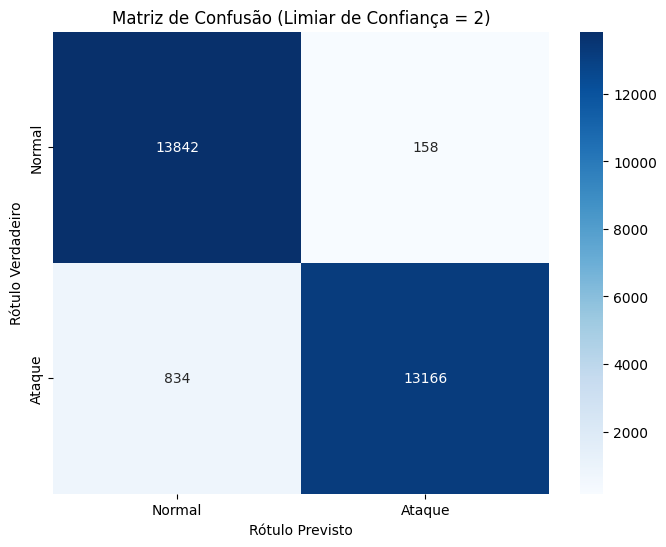

True Positives (TP): 13166
True Negatives (TN): 13842
False Positives (FP): 158
False Negatives (FN): 834

F1 Score: 0.9637
True Positive Rate (TPR) / Recall: 0.9404
True Negative Rate (TNR) / Specificity: 0.9887
--------------------
Threshold: 2
  Accuracy: 96.46%
  Avg. Inference Time: 0.0023 ms
  Early Exit Rate: 0.00% (0/28000)
--------------------




In [20]:
for model_id in range(len(model_names)):
    for loader in range(len(test_loaders)):
        for test in test_ids:
            if test == 1:
                T = 0.7
            elif test == 2:
                T = 0
            elif test == 3:
                T = 2
    
            print(f"--- Model: {model_names[model_id]} | Loader: {model_names[loader]} | TestID: {test} | Threshold: {T} ---")
    
            model.load_state_dict(torch.load(f'models/teste{test}/{model_names[model_id]}.pth'))
            print(f"Model from: 'models/teste{test}/{model_names[model_id]}.pth' carregado")
    
            results = evaluate_model(model, test_loaders[loader], confidence_threshold=T, device=device)
            print("-" * 20)
            print(f"Threshold: {T}")
            print(f"  Accuracy: {results['accuracy']:.2f}%")
            print(f"  Avg. Inference Time: {results['avg_inference_time_ms']:.4f} ms")
            print(f"  Early Exit Rate: {results['exit_rate']:.2f}% ({results['exited_early_count']}/{results['total_samples']})")
            print("-" * 20)
            print("\n")